In [30]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import pandas as pd
import pyfolio as pf
import numpy as np
import seaborn as sns
import pymc3 as pm
from scipy import stats
import empyrical as ep
import matplotlib.pyplot as plt

In [31]:
with pd.HDFStore('../data/assets.h5') as store:
    benchmark= store['sp500/prices'].close.to_frame('benchmark')
    returns = store['quandl/wiki/prices'].adj_close.unstack()['AMZN'].to_frame('stock')

In [32]:
data = returns.join(benchmark).pct_change().dropna().loc['2010':]
data.index = data.index.tz_localize('US/Eastern')

#### Bayesian Estimation Supersedes the T-Test

This model runs a Bayesian hypothesis comparing if y1 and y2 come
from the same distribution. Returns are assumed to be T-distributed.

In addition, computes annual volatility and Sharpe of in and
out-of-sample periods.

This model replicates the example used in:
Kruschke, John. (2012) Bayesian estimation supersedes the t
test. Journal of Experimental Psychology: General.

**Parameters**
- y1 : array-like
    - Array of returns (e.g. in-sample)
- y2 : array-like
    - Array of returns (e.g. out-of-sample)
- samples : int, optional
    - Number of posterior samples to draw.

**Returns**
- model : pymc.Model object
    - PyMC3 model containing all random variables.
- trace : pymc3.sampling.BaseTrace object
    - A PyMC3 trace object that contains samples for each parameter of the posterior.

**See Also**
- plot_stoch_vol : plotting of tochastic volatility model

$\tau = \dfrac{1}{\sigma^2}$

## Sharpe Ratio

### Define Probability Model

In [19]:
mean_prior = data.stock.mean()
std_prior = data.stock.std()
std_low = np.std(data.values) / 1000
std_high = np.std(data.values) * 1000

with pm.Model() as sharpe_model:
    mean = pm.Normal('mean',
                     mu=mean_prior,
                     tau=std_prior,
                     testval=data.stock.mean())

    std = pm.Uniform('std',
                     lower=std_low,
                     upper=std_high,
                     testval=data.stock.std())

    nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
    returns = pm.StudentT('returns',
                          nu=nu,
                          mu=mean,
                          sd=std,
                          observed=data.stock)
    
    pm.Deterministic('sharpe', 
                     returns.distribution.mean / returns.distribution.variance ** .5 * np.sqrt(252))    
    trace = pm.sample(draws=50000, n_init=5000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, std, mean]
Sampling 4 chains: 100%|██████████| 202000/202000 [01:01<00:00, 3309.86draws/s]
The acceptance probability does not match the target. It is 0.8964491350725203, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8983270431046748, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8986775677087268, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8857369698957412, but should be close to 0.8. Try to increase the number of tuning steps.


### Visualize Model

In [20]:
sharpe_model.named_vars

{'mean': mean,
 'std_interval__': std_interval__,
 'std': std,
 'nu_minus_two_log__': nu_minus_two_log__,
 'nu_minus_two': nu_minus_two,
 'returns': returns,
 'sharpe': sharpe}

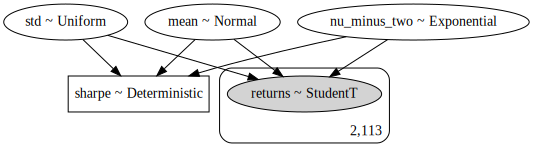

In [36]:
pm.model_to_graphviz(model=sharpe_model)

In [21]:
sharpe_model.model

In [27]:
from pymc3.plots import forestplot, autocorrplot, compareplot, plot_posterior,traceplot

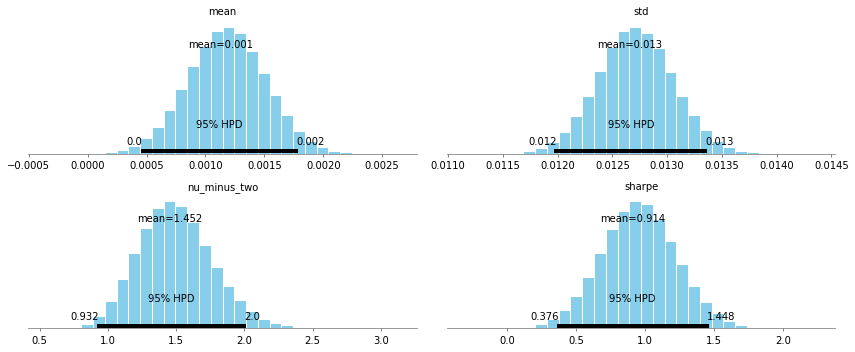

In [29]:
plot_posterior(trace=trace);

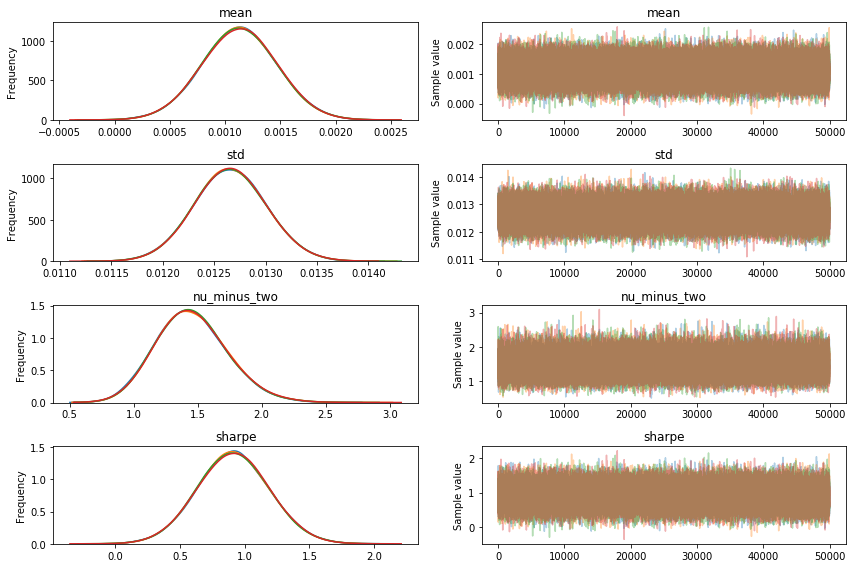

In [26]:
traceplot(trace=trace);

GridSpec(1, 2, width_ratios=[3, 1])

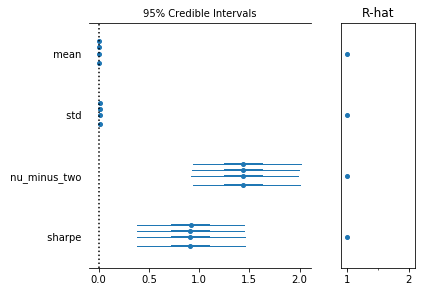

In [23]:
forestplot(trace=trace);

## Compare Sharpe Ratios

In [18]:
mu_m = data.stock.mean()
mu_p = 0.000001 / data.var()

std_low = np.std(data.values) / 1000
std_high = np.std(data.values) * 1000
with pm.Model() as model:
    
    pf_mean = pm.Normal('pf_mean', mu=mu_m, tau=mu_p, testval=data.stock.mean())
    benchmark_mean = pm.Normal('benchmark_mean', mu=mu_m, tau=mu_p, testval=data.benchmark.mean())

    pf_std = pm.Uniform('pf_std', lower=std_low,upper=std_high, testval=data.stock.std())
    benchmark_std = pm.Uniform('benchmark_std', lower=std_low, upper=std_high, testval=data.benchmark.std())

    nu = pm.Exponential('nu_minus_two', 1 / 29., testval=4.) + 2.

    returns_pf = pm.StudentT('pf',
                             nu=nu,
                             mu=pf_mean,
                             lam=pf_std ** -2,
                             observed=data.stock)
    returns_benchmark = pm.StudentT('benchmark',
                                    nu=nu,
                                    mu=benchmark_mean,
                                    lam=benchmark_std ** -2,
                                    observed=data.benchmark)

    diff_of_means = pm.Deterministic('difference of means', pf_std - pf_mean)
    pm.Deterministic('difference of stds', benchmark_std - pf_std)
    pm.Deterministic('effect size', diff_of_means /
                     pm.math.sqrt((pf_std ** 2 + benchmark_std ** 2) / 2))

    pm.Deterministic(
        'pf_vol', returns_pf.distribution.variance ** .5 * np.sqrt(252))
    pm.Deterministic(
        'benchmark_vol', returns_benchmark.distribution.variance ** .5 * np.sqrt(252))

    pm.Deterministic('pf_sharpe', returns_pf.distribution.mean / returns_pf.distribution.variance ** .5 *
                     np.sqrt(252))
    pm.Deterministic('benchmark_sharpe', returns_benchmark.distribution.mean / returns_benchmark.distribution.variance ** .5 *
                     np.sqrt(252))

    trace = pm.sample(draws=50000, n_init=5000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, benchmark_std, pf_std, benchmark_mean, pf_mean]
Sampling 4 chains: 100%|██████████| 202000/202000 [10:40<00:00, 315.25draws/s] 
The acceptance probability does not match the target. It is 0.9992238019689628, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9914407777902737, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9061129125306203, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9678593870217617, but should be close to 0.8. Try to increase the number of tuning steps.


In [ ]:
burn = 500
trace = trace[burn:]

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(16, 8), constrained_layout)
gs = gridspec.GridSpec(9, 2, wspace=0.3, hspace=0.3)
axs = axs.flatten()

def distplot_w_perc(trace, ax):
    sns.distplot(trace, ax=ax)
    ax.axvline(stats.scoreatpercentile(trace, 2.5), color='0.5', label='2.5 and 97.5 percentiles')
    ax.axvline(stats.scoreatpercentile(trace, 97.5), color='0.5')

sns.distplot(trace['group1_mean'], ax=axs[0], label='Backtest')
sns.distplot(trace['group2_mean'], ax=axs[0], label='Forward')
axs[0].legend(loc=0, frameon=True, framealpha=0.5)
axs[1].legend(loc=0, frameon=True, framealpha=0.5)

distplot_w_perc(trace['difference of means'], axs[1])

axs[0].set(xlabel='Mean', ylabel='Belief', yticklabels=[])
axs[1].set(xlabel='Difference of means', yticklabels=[])

sns.distplot(trace['group1_annual_volatility'], ax=axs[2], label='Backtest')
sns.distplot(trace['group2_annual_volatility'], ax=axs[2], label='Forward')
axs[2].set(xlabel='Annual volatility', ylabel='Belief', yticklabels=[])
axs[2].legend(loc=0, frameon=True, framealpha=0.5)

distplot_w_perc(trace['group2_annual_volatility'] - trace['group1_annual_volatility'], axs[3])
axs[3].set(xlabel='Difference of volatility', yticklabels=[])

sns.distplot(trace['group1_sharpe'], ax=axs[4], label='Backtest')
sns.distplot(trace['group2_sharpe'], ax=axs[4], label='Forward')
axs[4].set(xlabel='Sharpe', ylabel='Belief', yticklabels=[])
axs[4].legend(loc=0, frameon=True, framealpha=0.5)

distplot_w_perc(trace['group2_sharpe'] - trace['group1_sharpe'], axs[5])    
axs[5].set(xlabel='Difference of Sharpes', yticklabels=[])

sns.distplot(trace['effect size'], ax=axs[6])
axs[6].axvline(
        stats.scoreatpercentile(trace['effect size'], 2.5),
        color='0.5')
axs[6].axvline(
        stats.scoreatpercentile(trace['effect size'], 97.5),
        color='0.5')
axs[6].set(xlabel='Difference of means normalized by volatility',
           ylabel='Belief', yticklabels=[])